In [ ]:
import rebel_decode as rd
p_info = rd.parse_public_data("../out/0001_public.txt")
REBS=p_info.get_rebs()
COT=p_info.get_cot() # df 
NEA=p_info.get_nea() # df
LOC=p_info.get_loc() # df
FLAVOUR_DICT=p_info.get_flavour_dict()

truth = rd.parse_truth_data("../out/0001_truth.txt")
star_coords = truth.get_stars()
ship_movements = truth.get_moves()
messages = truth.get_messages()

_Objective_

Predict true positions using public data.

H1: Cotravellers/ship predicts true positions, because ships follow different routes.

H2: Leaked noisy coordinates are (endogenous) predictors of true positions.

H3: Nearest star itself has a position and therefore (endogenously) predict true positions.


In [42]:
import pandas as pd

# generate 1000 X rebel df because REBS appears not to be a dict (it includes headers)
rebs_df = pd.read_csv('../out/0001_public.txt',
                 header=None, engine='python',
                 sep='t=(\d+), (\w+), (\w+), (.*)').dropna(how='all', axis=1) # regex from rebel_decode.py
rebs_df.columns=['t', 'msg_type', 'messenger', 'msg_content']
rebs_df.reset_index(drop=True)

rebs_df = rebs_df[['t','messenger','msg_type']]
rebs_df = rebs_df.set_index('t')\
            .groupby('messenger')\
            .apply(lambda df_x: df_x.reindex(range(1, 1000+1)))\
            .drop('messenger', axis=1).reset_index()

# We know that some rebels travel together at all times. We can tie the rebels
# together using the names and the leaked cotraveller names (including who 
# leaked the names).
import networkx as nx

relations = nx.from_pandas_edgelist(COT, source='messenger', target='cotraveller')

# Figure out the number of ships based on ties in the relations using 
# `connected_components`, and use `enumerate` to assign shipnumber to rebel names.
ships = {rebel: ship for ship, shipnumber in enumerate((nx.connected_components(relations))) for rebel in shipnumber}

# Add ships to rebs_df
rebs_df['ship'] = rebs_df['messenger'].map(ships)

# Are all rebels aboard a ship?
rebs_df['ship'].isna().sum() # yes

# How many ships are there in the graded assigment?
rebs_df.ship.nunique() # 4

# List all passengers of each ship in the graded assignment
pd.Series(ships)

,messenger,t,msg_type,ship
0,Ane,1,NEA,3
1,Ane,2,NaN,3
2,Ane,3,NaN,3
3,Ane,4,NaN,3
4,Ane,5,NaN,3
...,...,...,...,...
32995,Yolanda,996,NaN,3
32996,Yolanda,997,NaN,3
32997,Yolanda,998,NaN,3
32998,Yolanda,999,NaN,3


In [ ]:
# What type of leaks are most common? (are they?)
rebs_df.info()
rebs_df.value_counts('msg_type') # COT 699 > NEA 537 > LOC 342
    # Rebels leaking cotraveller may leak more often than rebels leaking other msg_types
    # There may be more rebels leaking cotraveller than rebels leaking other msg_types
rebs_df.groupby(['msg_type'])['messenger'].nunique() # COT 14 > NEA 11 > LOC 8
    # The ratio of leaks to leakers per msg_type: COT 49 > NEA 48 > LOC 42
    # Some leaks seem more common than others, even when considering the number of leakers.
    # There are fewer rebels leaking LOC, and these rebels leak less than other rebels.


_leaks and missing values_

We hope to use leaks to predict positions. There are not that many leaks compared to the many positions we know they take. This makes it difficult to predict. For this reason we wonder whether we should use techniques to impute missing data. We have to consider whether the lack of leaks means that there are not leaks and are truly 'not there', or whether we might insist that just because information is not leaked, the information must still be there; e.g. messengers/rebeles must:
- have cotravellers (be on a ship)
- have noisy positions
- be closer to some stars that others

I believe we can fairly say that this is true. Nonetheless, it is still true that leak is an individual level predictor (not ship level). So differences in leaks (that inform the outcome of interest) can be attributed to differences among rebels (type/flavour). This suggests that variation in leaks is not 'completely random', but 'random': When there is no leak, the leak is missing at random, e.g. due to known differences in rebels. In this sense, 'not leaking' reveals predictive information. But we do not know why some rebels leak and other do not, and why they leak different messages. Could the reason for
their leaks and lack of leaks be confounded? In other words, is it 'missing not at random': Is some underlying factor related to the leaks determining the leaks? More generally, what determines whether information is leaked or not? And is the variation in leaks (and missing leaks/values) related to true space-time positions?

Public leak rates are the number of non-NaN to sum(non-NaN + NaN).
It may be the case that we are more interested in the rate of certain types of leaks.
- We know what ship rebels/messagers belong to.
- We know less about the nearest star and the noisy coordinates.
- We can simply impute the nearest star to all rebels on the same ship.
- The question is how to impute noisy coordinates since we are not given the underlying
function.

Are public leaks (non leaks ~ missing values) conditional on what we predict?

Eventually we can use this to handle missing values.

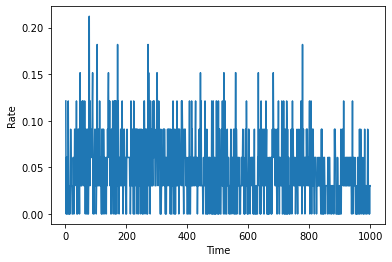

<AxesSubplot:>

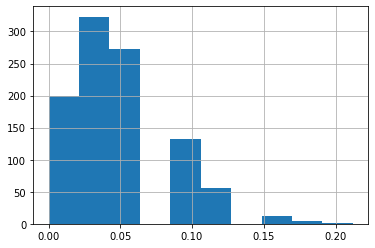

In [44]:
# Are public leak rates independent of time/position? If not, 
# can you determine the analytical function that govern the rates? 

# The 3d visualization indicates that messages are not extremely 
# scattered but rather cluster together around star clusters.

rebs_df[['msg_type']].apply(lambda df_x: 1-(df_x.count()/df_x.size))
g_time = rebs_df.groupby(['t']) # 'x', 'y', 'z'
non_nan_time = g_time['msg_type'].count() # count non-NaN
total_time = g_time.size() # total number of values (including NaN) for each time
leak_rate_time = non_nan_time / total_time
leak_rate_time.describe()
"""
count    1000.000000
mean        0.047818
std         0.037106
min         0.000000
25%         0.030303
50%         0.030303
75%         0.060606
max         0.212121
dtype: float64
"""
leak_rate_time.skew() # 0.728 ~ slightly skewed toward zero
leak_rate_time.kurt() # 0.480 ~ quite flat

import matplotlib.pyplot as plt
plt.plot(leak_rate_time)
plt.xlabel('Time')
plt.ylabel('Rate')
plt.show() 

leak_rate_time.hist()

In [ ]:
# focus on types of leaks
rebs_df['msg_type'].unique()

# rebs_df[['msg_type']].apply(lambda df_x: 1-(df_x[rebs_df['msg_type'] == 'LOC'].count()/df_x.size))
# rebs_df[['msg_type']].apply(lambda df_x: 1-(df_x[rebs_df['msg_type'] == 'NEA'].count()/df_x.size))
# rebs_df[['msg_type']].apply(lambda df_x: 1-(df_x[rebs_df['msg_type'] == 'COT'].count()/df_x.size))

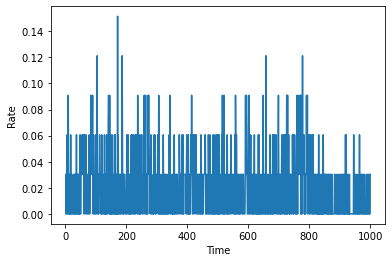

<AxesSubplot:>

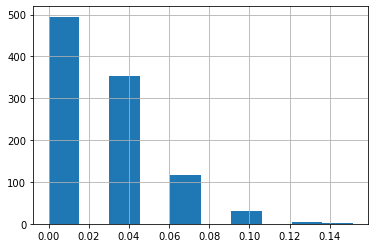

In [7]:
COT_non_nan_time = g_time.apply(lambda df_x: df_x[df_x['msg_type'] == 'COT']['msg_type'].count())
COT_total_time = g_time.size()
COT_leak_rate_time = COT_non_nan_time / COT_total_time
COT_leak_rate_time.describe()
COT_leak_rate_time.skew() 
COT_leak_rate_time.kurt() 

plt.plot(COT_leak_rate_time)
plt.xlabel('Time')
plt.ylabel('Rate')
plt.show()

COT_leak_rate_time.hist()

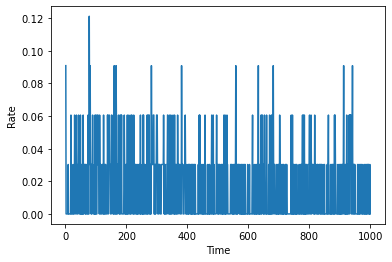

<AxesSubplot:>

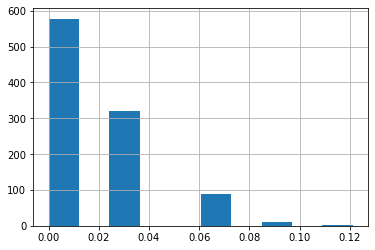

In [8]:
NEA_non_nan_time = g_time.apply(lambda df_x: df_x[df_x['msg_type'] == 'NEA']['msg_type'].count())
NEA_total_time = g_time.size() 
NEA_leak_rate_time = NEA_non_nan_time / NEA_total_time
NEA_leak_rate_time.describe()
NEA_leak_rate_time.skew() 
NEA_leak_rate_time.kurt() 

plt.plot(NEA_leak_rate_time)
plt.xlabel('Time')
plt.ylabel('Rate')
plt.show()


NEA_leak_rate_time.hist()

_Summary: Independence of time?_

Missingness varies over time  for important predictors of xyz with many missing values. Albeit the pattern may not look clear.

In [45]:
# ... Independent of space?
# The 3d visualizations seem to indicate that the public leak messages are 
# dependent on space, because the messages appear less scattered.

# To figure out how leaks vary with position, we need to join truth data
# (we also need truth data to train the model).
# We insert truth coordinates in the rebs_df. then we can examine the true movements.

# true positions of ships at all times
ship_movements = truth.get_moves()
ship_movements['ship'] = ship_movements['id'].apply(lambda id_x: int(id_x.split('_')[1])) # split, tak the last item, to int
ship_movements.rename({'x': 'x_truth', 'y': 'y_truth', 'z': 'z_truth'}, axis=1, inplace=True)
ship_movements = ship_movements[['t','x_truth','y_truth','z_truth','ship']]

rebs_df_wtruth = pd.merge(rebs_df,ship_movements, how='left',on=['t','ship'])
rebs_df_wtruth


,messenger,t,msg_type,ship,x_truth,y_truth,z_truth
0,Ane,1,NEA,3,247.412741,835.240656,23.806575
1,Ane,2,NaN,3,229.365189,836.082003,52.226273
2,Ane,3,NaN,3,235.802308,814.621006,27.616022
3,Ane,4,NaN,3,231.466046,819.051800,39.715736
4,Ane,5,NaN,3,221.639363,824.695333,37.014200
...,...,...,...,...,...,...,...
32995,Yolanda,996,NaN,3,819.260380,543.303721,265.707305
32996,Yolanda,997,NaN,3,836.613344,567.866453,227.877650
32997,Yolanda,998,NaN,3,856.964482,575.495436,260.473307
32998,Yolanda,999,NaN,3,836.613344,567.866453,227.877650


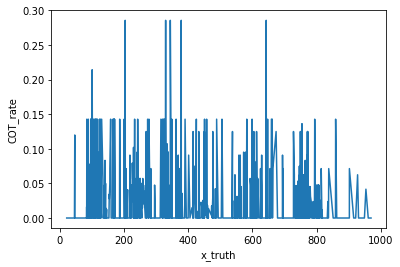

<AxesSubplot:>

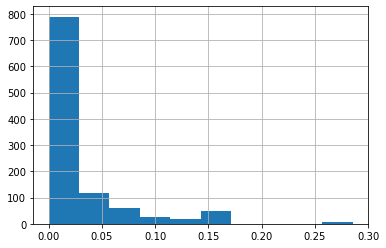

In [34]:
g_x = rebs_df_wtruth.groupby(['x_truth']) # 'x', 'y', 'z'
COT_non_nan_x = g_x.apply(lambda df_x: df_x[df_x['msg_type'] == 'COT']['msg_type'].count())
COT_total_x = g_x.size() # total number of values (including NaN) for each time
COT_leak_rate_x = COT_non_nan_x / COT_total_x
COT_leak_rate_x.describe()
"""
count    1064.000000
mean        0.022424
std         0.042664
min         0.000000
25%         0.000000
50%         0.000000
75%         0.028846
max         0.285714
dtype: float64
"""
COT_leak_rate_x.skew() # 2.572 ~ skewed toward zero
COT_leak_rate_x.kurt() # 8.089 ~ not flat

plt.plot(COT_leak_rate_x)
plt.xlabel('x_truth')
plt.ylabel('COT_rate')
plt.show()

COT_leak_rate_x.hist()

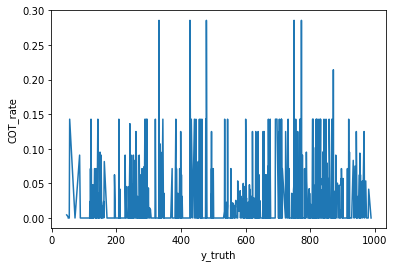

<AxesSubplot:>

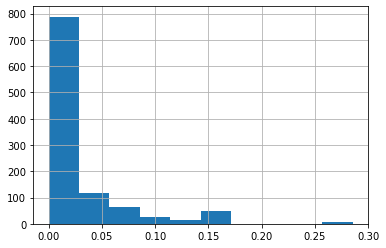

In [33]:
g_y = rebs_df_wtruth.groupby(['y_truth']) # 'x', 'y', 'z'
COT_non_nan_y = g_y.apply(lambda df_x: df_x[df_x['msg_type'] == 'COT']['msg_type'].count())
COT_total_y = g_y.size() # total number of values (including NaN) for each time
COT_leak_rate_y = COT_non_nan_y / COT_total_y
COT_leak_rate_y.describe()
# """
# count    1060.000000
# mean        0.022133
# std         0.042225
# min         0.000000
# 25%         0.000000
# 50%         0.000000
# 75%         0.028571
# max         0.285714
# dtype: float64
# """
COT_leak_rate_y.skew() # 2.616 ~ skewed toward zero
COT_leak_rate_y.kurt() # 8.487 ~ not flat

plt.plot(COT_leak_rate_y)
plt.xlabel('y_truth')
plt.ylabel('COT_rate')
plt.show()

COT_leak_rate_y.hist()

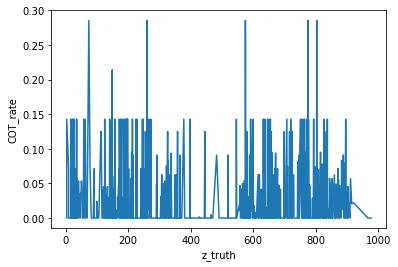

<AxesSubplot:>

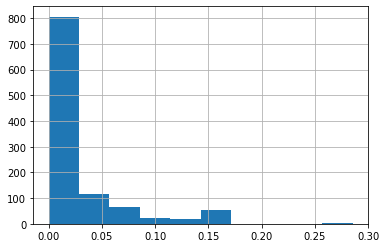

In [29]:
g_z = rebs_df_wtruth.groupby(['z_truth']) # 'x', 'y', 'z'
COT_non_nan_z = g_z.apply(lambda df_x: df_x[df_x['msg_type'] == 'COT']['msg_type'].count())
COT_total_z = g_z.size() # total number of values (including NaN) for each time
COT_leak_rate_z = COT_non_nan_z / COT_total_z
COT_leak_rate_z.describe()
"""
count    1086.000000
mean        0.022643
std         0.043027
min         0.000000
25%         0.000000
50%         0.000000
75%         0.028846
max         0.285714
dtype: float64
"""
COT_leak_rate_z.skew() # 2.529 ~ skewed toward zero
COT_leak_rate_z.kurt() # 7.707 ~ not flat

plt.plot(COT_leak_rate_z)
plt.xlabel('z_truth')
plt.ylabel('COT_rate')
plt.show()

COT_leak_rate_z.hist()

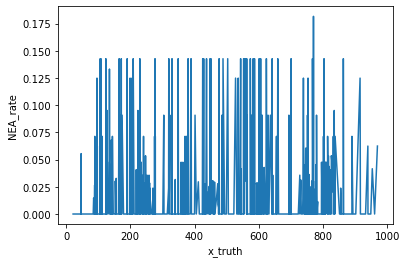

<AxesSubplot:>

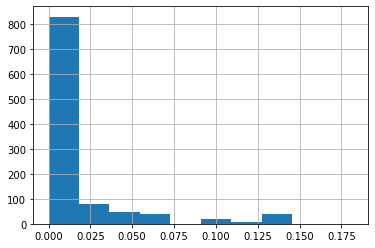

In [30]:
NEA_non_nan_x = g_x.apply(lambda df_x: df_x[df_x['msg_type'] == 'NEA']['msg_type'].count())
NEA_total_x = g_x.size() # total number of values (including NaN) for each time
NEA_leak_rate_x = NEA_non_nan_x / NEA_total_x

plt.plot(NEA_leak_rate_x)
plt.xlabel('x_truth')
plt.ylabel('NEA_rate')
plt.show()

NEA_leak_rate_x.hist()



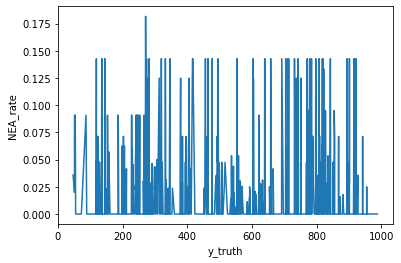

<AxesSubplot:>

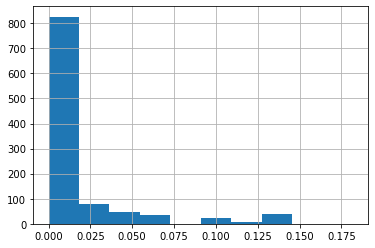

In [31]:
NEA_non_nan_y = g_y.apply(lambda df_x: df_x[df_x['msg_type'] == 'NEA']['msg_type'].count())
NEA_total_y = g_y.size() # total number of values (including NaN) for each time
NEA_leak_rate_y = NEA_non_nan_y / NEA_total_y
NEA_leak_rate_y.describe()
NEA_leak_rate_y.skew()
NEA_leak_rate_y.kurt()

plt.plot(NEA_leak_rate_y)
plt.xlabel('y_truth')
plt.ylabel('NEA_rate')
plt.show()

NEA_leak_rate_y.hist()


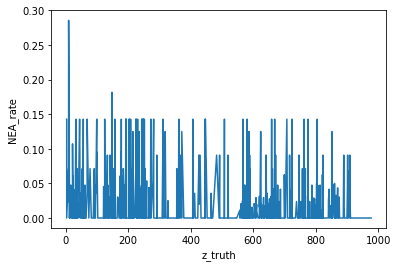

<AxesSubplot:>

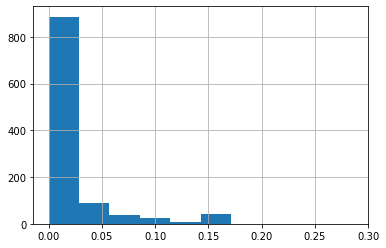

In [32]:
g_z = rebs_df_wtruth.groupby(['z_truth']) # 'x', 'y', 'z'
NEA_non_nan_z = g_z.apply(lambda df_x: df_x[df_x['msg_type'] == 'NEA']['msg_type'].count())
NEA_total_z = g_z.size() # total number of values (including NaN) for each time
NEA_leak_rate_z = NEA_non_nan_z / NEA_total_z
NEA_leak_rate_z.describe()
NEA_leak_rate_z.skew()
NEA_leak_rate_z.kurt()

plt.plot(NEA_leak_rate_z)
plt.xlabel('z_truth')
plt.ylabel('NEA_rate')
plt.show()

NEA_leak_rate_z.hist()

_Summary: Independence of space_

Missingness varies with space for important predictors of xyz with many missing values.

However, xyz coordinates are probably related because stars cluster more or less. And ships tend to move around clusters of stars, which is why movements tend to cluster. This may suggest that controlling for nearest star help to account for the degree of moving in a cluster.

_Can I determine the analytical function?_

The variation in leaks/missingness does not look very systematic. It is difficult to tell whether leaks tend to come from certain positions or times, and, conversely, whether values are missing systematically across different space time positions.

Determiming an analytical function of missingness/leaks requires conditioning on time-space. This means it involves conditioning on txyz., like the visualization showing the distribution.

**One approach is to  estimate the function of missingness.**

**Another approach is to impute using a method that preserves ***(a) uncertainty (b) accuracy***.**

In [174]:
# concatenate all 10 previous travel patterns to increase information to the multiple imputation model (Amelia)

import os
directory = "../out/"
preprocessed = []
COT_times = []
ts_ship_ids = set()

for i in range(1,11):

    file_number = str(i).zfill(4) # 0001-0010
    public_file = os.path.join(directory, f"{file_number}_public.txt")
    truth_file = os.path.join(directory, f"{file_number}_truth.txt")

    p_info = rd.parse_public_data(public_file) # "0001_public.txt"
    REBS=p_info.get_rebs()
    COT=p_info.get_cot() # df 
    NEA=p_info.get_nea() # df
    LOC=p_info.get_loc() # df
    FLAVOUR_DICT=p_info.get_flavour_dict()

    truth = rd.parse_truth_data(truth_file) # "../out/0001_truth.txt"
    star_coords = truth.get_stars()
    ship_movements = truth.get_moves()
    messages = truth.get_messages()

    rebs_df = pd.read_csv(public_file,
                    header=None, engine='python',
                    sep='t=(\d+), (\w+), (\w+), (.*)').dropna(how='all', axis=1) # regex from rebel_decode.py
    rebs_df.columns=['t', 'msg_type', 'messenger', 'msg_content']
    rebs_df.reset_index(drop=True)

    rebs_df = rebs_df[['t','messenger','msg_type']]
    rebs_df = rebs_df.set_index('t')\
                .groupby('messenger')\
                .apply(lambda df_x: df_x.reindex(range(1, 1000+1)))\
                .drop('messenger', axis=1).reset_index()

    relations = nx.from_pandas_edgelist(COT, source='messenger', target='cotraveller')
    ships = {rebel: ship for ship, shipnumber in enumerate((nx.connected_components(relations))) for rebel in shipnumber}
    
    rebs_df['ship'] = rebs_df['messenger'].map(ships)

    ship_movements['ship'] = ship_movements['id'].apply(lambda id_x: int(id_x.split('_')[1])) # split, tak the last item, to int
    ship_movements.rename({'x': 'x_truth', 'y': 'y_truth', 'z': 'z_truth'}, axis=1, inplace=True)
    ship_movements = ship_movements[['t','x_truth','y_truth','z_truth','ship']]

    rebs_df_wtruth = pd.merge(rebs_df,ship_movements, how='left',on=['t','ship'])
    
    rebs_df_wtruth['timeseries'] = f'ts_{i}'
   
    # # make sure ships from different timeseries are not mixed up
    # shipnums = {}
    # max_shipnum = rebs_df_wtruth['ship'].max() # .astype(int)
    # for j in range(max_shipnum + 1):
    #     ts_ship_num = f'ts_{i}_ship_{j}'
    #     while ts_ship_num in ts_ship_ids:
    #         ts_ship_num = ts_ship_num + '_'
    #     shipnums[j] = ts_ship_num
    #     ts_ship_ids.add(ts_ship_num)
    # rebs_df_wtruth['ship'] = rebs_df_wtruth['ship'].apply(lambda x: shipnums[x])

    preprocessed.append(rebs_df_wtruth)
    COT_times.append(COT)

    

rebel_times = pd.concat(preprocessed, axis=0) #, ignore_index=True)
# COT_times = pd.concat(COT_long, axis=0) #, ignore_index=True)

# run network analysis again, so as to make sure ships with the same rebels have the same value in the ship col
# relations = nx.from_pandas_edgelist(COT_times, source='messenger', target='cotraveller')
# ships = {rebel: ship for ship, shipnumber in enumerate((nx.connected_components(relations))) for rebel in shipnumber}
# rebel_times['ship_across'] = rebel_times['messenger'].map(ships)

rebel_times.describe(include='all')

[rebel_decode.py: -    parse_public_data() ]  ... Parsing public data!
[rebel_decode.py: -    parse_public_data() ]  ... Done parsing public!
[rebel_decode.py: -     parse_truth_data() ]  ... Parsing truth data!
[rebel_decode.py: -     parse_truth_data() ]  ... Done parsing truth!
[rebel_decode.py: -    parse_public_data() ]  ... Parsing public data!
[rebel_decode.py: -    parse_public_data() ]  ... Done parsing public!
[rebel_decode.py: -     parse_truth_data() ]  ... Parsing truth data!
[rebel_decode.py: -     parse_truth_data() ]  ... Done parsing truth!
[rebel_decode.py: -    parse_public_data() ]  ... Parsing public data!
[rebel_decode.py: -    parse_public_data() ]  ... Done parsing public!
[rebel_decode.py: -     parse_truth_data() ]  ... Parsing truth data!
[rebel_decode.py: -     parse_truth_data() ]  ... Done parsing truth!


TypeError: 'numpy.float64' object cannot be interpreted as an integer

## Final thoughts

Having observed that the network program worked on the first timeseries (on public, then join with truth), I thought I could use it on the rest, and concatenate the dataframes (along with the other information).

Then--because I had noticed there were different numbers of ships across some of the 10 datasets--I believed I could rerun the network program on the concatenated df, using concatenated COT dataframes, to recalibrate the data to the outlined rule: that unique rebels never enter or leave ships, nor the universe. In this way, I could join the information on ships within each timeseries, and afterwards make sure that rebels were assigned only one ship.

To my surprise, the network program, with more (full) data, appeared to tie all rebels to each other! At least, it outputted only one group. I thought I might have misunderstood the premise/rule, or that I misspecified the program or its inputs. It was not apparent what was wrong, however.

So I changed strategy to try to recode ships (integers; ordinal/interval scaled) to unique nominal identifiers by the end of each iteration/timeseries. That is, to impose the lack of any similarity of ships and ship members. And that was when I found out that some rebels had not been assigned to a ship in the third public dataset, because they had not been mentioned in the COT leaks (which I knew was a possibility, however, that did not cause issues in the first public dataset. ).

A next step here could be to figure out whether (a) the network program handled the concatenated COT data in a way such that the lack of mentions ruined the components (and how to fix it), or (b) it would be possible to accept that the concatenation of all ten timeseries would result in some bias and perhaps error due to the poor measurement of rebel assignment to ship (in light of my interpretation of the rules of the universe).

In [ ]:
# to do



# missing value imputation with Amelia

# model the relationship (ideally, multiple output models, equation for each coordinate)

# apply preprocessing and model to assignment data

# save result in .txt

In [268]:

# make df with all data to be used for imputation
# 1. public
# messenger/reb
# t
# ship
# x_leak
# y_leak
# z_leak
# nearest_star
# 2. truth
# x_truth
# y_truth
# z_truth
# x_star_position ?
# y_star_position ?
# z_star_position ?

# star_coords = truth.get_stars()
# star_coords # star coordinates: link star ID with x y z
star_coords # star coordinates: link star ID with x y z
ship_movements # true positions of ships at all times
messages # all public messages with true positions

# perhaps use information about predicted positions to predict the positions of stars
# that, via information about the ship, can in turn be used to predict more positions


In [ ]:
# impute missing values based on reasonable assumptions

# add nearest star at t, leaked by any shipmember to all shipmembers 
NEA['ship'] = NEA['messenger'].map(ships)
rebs_df = pd.merge(rebs_df,NEA[['t','ship','closestStar']]\
                   ,how='left',on=['ship','t'])\
                   .drop_duplicates(subset=['t','messenger','ship','closestStar',])
# rebs_df = pd.merge(rebs_df,NEA[['messenger','t','closestStar']], how='left',on=['messenger','t']) # only to leaking rebels, not ship


# add leaked coordinates
rebs_df = pd.merge(rebs_df,LOC[['messenger','t','x','y','z']], how='left',on=['messenger','t'])
    # must related to coordinates of all shipmembers, but we dont know how
    # bias and error: what function maps signals from truth?
    # If the missingness of the data can be explained by confounders/variables we observe
    # then may assume the leaked coordinates are missing at random.
    # If the distribution of xyz is likely to be similar for 
    # 1) rebel and t and 2) msg_type(!)

"""_impute avg of leaked coordinates?_

# impute averages of leaked coordinates per ship at a given time on the rest
# LOC['ship'] = LOC['messenger'].map(ships)
# LOC.describe(include='all') # do we have some coordinates of all ships?
ship_LOC_avg = LOC.groupby(['t','ship'], as_index=False).mean(numeric_only=True)[['t','ship','x','y','z']]
ship_LOC_avg.columns=['t', 'ship', 'x_avg', 'y_avg','z_avg']
rebs_df = rebs_df.merge(ship_LOC_avg, how='left',on=['ship','t'])
rebs_df['x','y','z'] = rebs_df['x','y','z'].fillna(rebs_df['x_avg','y_avg','z_avg'])
rebs_df
rebs_df.describe(include='all')

# perhaps forward fill NaN with some regression between values

"""

# Can we treat leaked positions (and perhaps NEA) as samples of the truth?
# df_rebs['x','x_truth'].hist(by=df['msg_type']) # or perhaps t

# add leaked coordinates
# rebs_df = pd.merge(rebs_df,LOC[['messenger','t','x','y','z']], how='left',on=['messenger','t'])
    # must related to coordinates of all shipmembers, but we dont know how
    # bias and error: what function maps signals from truth?
    # If the missingness of the data can be explained by confounders/variables we observe
    # then may assume the leaked coordinates are missing at random.
    # If the distribution of xyz is likely to be similar for 
    # 1) rebel and t and 2) msg_type(!)


In [151]:
# load Amelia for handling missing data
from rpy2.robjects.packages import importr
from rpy2.robjects import r
from rpy2.robjects import pandas2ri 


Amelia = importr('Amelia')
dir(Amelia)
Amelia.


['AmeliaView', '___NAMESPACE___', '___S3MethodsTable___', '__doc__', '__loader__', '__name__', '__package__', '__rdata__', '__rname__', '__spec__', '__version__', '_env', '_exported_names', '_onAttach', '_packageName', '_rpy2r', '_symbol_check_after', '_symbol_r2python', '_translation', 'activateGUI', 'addBounds', 'addLag', 'addLead', 'after', 'amcheck', 'amelia', 'ameliaEnv', 'ameliaTclSet', 'amelia_amelia', 'amelia_default', 'amelia_impute', 'amelia_molist', 'amelia_prep', 'amelia_save', 'ameliabind', 'amstack', 'amsubset', 'amtransform', 'amunstack', 'bandTree', 'bindTooltip', 'bootx', 'buildAboutDialog', 'buildNumericalOptions', 'buildOutputOptions', 'cancel_after', 'centerModalDialog', 'combine_output', 'compare_density', 'disperse', 'drawArrow', 'drawMissMap', 'dropLag', 'dropLead', 'dropTrans', 'emarch', 'est_matrix', 'fillMainTree', 'frame_to_matrix', 'generatepriors', 'getAmelia', 'getAmeliaInd', 'getOriginalData', 'gethull', 'gui_diag_setup', 'gui_pri_setup', 'impfill', 'indx

_We said rebel movements are not completely random. Is this true?_

A rebel movement may be defined as a difference in 3 dimensional space from one time to the next. The 3d visualizations strongly indicates that rebel movements are not completely random, but random in the sense that they are dependent on time and space: Positions are strongly correlated conditioned on ship, time, and space. In other words, the these variables are strongly predictive of where the ship may be: Ships move only so far from one time to the next. Conversely, being completely random would imply that values are equally probably. We can plot the value frequency distributions of the positions to get a sense of that, which I believe is unlikely.

If rebel movements were completely random, we would not care to try to predict it (how could we?). We would also not care about missing values, since missing and non missing values would be equally good at predicting movements. However, if we lacked observations to power the methods, then we could impute values, to gain more confidence.